# Screening Task 1 for QOSF Mentorship

## Problem statement

The idea of task 1 is to implement the following variational circuit that prepares a 4 qubit state $| \Psi(\theta)\rangle$

<img src="images/circuit1.jpg">

Here, we call as a layer to the combination of an odd block (yellow) and an even block (green). The number of layers denoted by $L$ is an hyperparameter of the variational circuit.

Specifically, each block is defined as follows:

                                             Odd block
<img src="images/odd_block.jpg" style="width:350px;height:150px"/>

                                             Even block
<img src="images/even_block.jpg" style="width:500px;height:150px"/>

Where the double qubits gates are $CZ$ gates and a layer of the variational circuit is composed by 8 parameters denoted by $\theta_{i, n}$ (4 parameters per block).

The idea is to report with a plot, as a function of the number of layers, the minimum distance

$\varepsilon = min_{\theta}\left \| |\Psi(\theta) - \phi \rangle \right \|$

Where $|\phi\rangle$ is a randomly generated vector of 4 qubits, i.e. 16 dimensions, and $\left \| v \rangle \right \| = \sqrt{\langle v| v \rangle} = \sqrt{v^{\dagger}v}$. The right set of parameters $\theta_{i, n}$ can be found via any method of choice.

You can go to the source document where all the screening tasks are explained and discussed <a href="https://docs.google.com/document/d/1Ow3v8Y4rYBdgxXNxKV9ZUAM4bwL6211U6DWCcByZ4A4/edit" target="_blank">here</a>.

## Overview of this work

This work is organized as follows:

1. Generate a proper random quantum state, its probability vector, density matrix and quantum fidelity.


2. Building the variational quantum circuit using `Qiskit`.


3. Optimization of the variational circuit in `Qiskit Aer StatevectorSimulator` backend `COBYLA` optimizer. Minimizing the Euclidean distance of two complex vectors.


4. Optimization of the variational circuit in `Qiskit Aer QasmSimulator` backend `COBYLA` optimizer. Minimizing the diagonal terms of two density matrices or minimizing the probability distribution of the outcomes in a given basis.


5. Building the variation quantum circuit using `Pennylane`.


6. Optimizating Quantum Fidelity in `Pennylane` using `GradientDescentOptimizer` optimizer. Maximizing the quantum fidelity between two quantum states or maximizing the probability of observing the system to be in a target quantum state.


<a href="https://qiskit.org/documentation/tutorials/simulators/1_aer_provider.html" target="_blank">Qiskit Aer Simulators.</a>

$\mathrm{Re}\left \{ \langle \Psi(\theta) - \phi| \Psi(\theta) - \phi \rangle \right \} = 1$

### Imports

In [1]:
import pennylane as qml
from pennylane import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer, IBMQ
from qiskit.visualization import plot_histogram, plot_state_city
from qiskit.aqua.components.optimizers import COBYLA
import matplotlib.pyplot as plt

## Define some useful plot functions

In [2]:
def plot_density_matrix(n_layers, params): 
    
    qc = build_variational_circuit(n_layers, params)
    backend = Aer.get_backend('statevector_simulator')
    statevector = execute(qc, backend).result().get_statevector(qc, decimals = 3)

    return plot_state_city(statevector, title=f'State after optimization of a {n_layers} layer variational circuit')
    
def plot_measurements(n_layers, params):
    
    qc = build_variational_circuit(n_layers, params)
    NUM_SHOTS = 10000
    backend = Aer.get_backend("qasm_simulator")
    qc.measure_all()
    result = execute(qc, backend, shots = NUM_SHOTS).result()
    counts = result.get_counts(qc)
    return plot_histogram(counts, title=f'State counts after optimization of {n_layers} layer circuit')

## Generating a proper random quantum state and its probability vector

Explain some things here
$|\psi\rangle \rightarrow |\psi\rangle \langle \psi |$

In [3]:
def norm(complex_vector: np.array) -> float:
    """Returns the norm of a complex vector.
    
    Args:
       complex_vector (np.arrray of shape (dim,)):
           complex vector with an arbitrary dimension.
           
       
    Returns:
        norm (float): norm or magnitude of the complex vector.
            
    """
    
    #define the norm of a complex vector here
    norm = np.sqrt(sum([np.square(np.absolute(complex_vector[i])) for i in range(complex_vector.shape[0])]))
    
    return norm

def random_quantum_state(dim: int, amplitude_type: str = 'complex') -> np.array:
    """Creates a normalized random real or complex vector of a defined
    dimension.
    
    Args:
        dim (int): integer number specifying the dimension
            of the vector that we want to generate.
            
        amplitude_type (str): string indicating if you want to create a
            vector with 'complex' or 'real' number amplitudes.
            
    Returns:
        (np.array): normalized real or complex vector of the given
            dimension.
    """
    #generate an unnormalized complex vector of dimension = dim
    if amplitude_type == 'complex':
        Z = np.random.random(dim) + np.random.random(dim)*1j
    
    #generate an unnormalized real vector of dimension = dim
    elif amplitude_type == 'real':
        Z = np.random.random(dim)
    
    #normalize the complex vector Z
    Z /= norm(Z)
    
    return Z

def get_probabilities(complex_vector: np.array) -> np.array:
    """Get the probabilities associated to a quantum state.
    This is a vector in which each element is the square of
    the magnitude of the respective complex number in that element.
    
    Args:
        complex_vector (np.array):
        
    Retuns:
        (np.array): 
    """
    
    if 1.0 - norm(complex_vector) > 0.001:
        print("Alert! The quantum state apparently is not normalized.")
        
    else:
        return np.square(np.absolute(complex_vector))
    
def density_matrix(target_vector: np.array) -> np.array:
    
    target_vector_reshape = target_vector.reshape((target_vector.shape[0],1))
    density_matrix = target_vector_reshape @ np.transpose(np.conjugate(target_vector_reshape))
    
    return density_matrix

def quantum_fidelity(v1: np.array, v2: np.array) -> float:
    
    v1_reshape = v1.reshape((v1.shape[0], 1))
    v2_reshape = v2.reshape((v2.shape[0], 1))
    
    inner_product = np.transpose(np.conjugate(v1_reshape)) @ v2_reshape
    
    return np.square(np.absolute(inner_product))[0][0]

In [4]:
#two qubits -> a complex vector of dimension 4
n_qubits = 1
dim = 2**(n_qubits)
psi = random_quantum_state(dim)
psi

tensor([0.03068554+0.52050094j, 0.52431288+0.67322594j], requires_grad=True)

In [5]:
get_probabilities(psi)

tensor([0.27186284, 0.72813716], requires_grad=True)

In [6]:
quantum_fidelity(psi, psi)

0.9999999999999998

In [7]:
v1 = np.array([1/np.sqrt(2), 1/np.sqrt(2)])
v2 = np.array([1/np.sqrt(2), -1/np.sqrt(2)])
quantum_fidelity(v1, v2)

0.0

## Building the variational quantum circuit in Qiskit

In [8]:
def build_variational_circuit(number_layers: int, params: np.array) -> QuantumCircuit:
    """Build the variational quantum circuit with a defined
    number of layers.
    
    Arguments:
        number_layers (int): number of layers that we want.
        
        params (np.array): np.array of shape (8*number_layers,)
            with the set of angles for the complete variational
            circuit.
            
    Returns:
        (QuantumCircuit): QuantumCircuit object from Qisikit.
            This is our variational quantum circuit.
    """
    
    #number of parameters depending on the number of layers-
    n_parameters = 8*number_layers
    
    if params.shape[0] != n_parameters:
        print(f"Alert! You gave {params.shape[0]} parameters for a circuit of {n_parameters} parameters.")
        
    else:
        #create the circuit
        qr = QuantumRegister(4, name="q")
        cr = ClassicalRegister(4, name="c")
        qc = QuantumCircuit(qr, cr)

        #number of parameters per layer
        n_parameters_per_layer = 8
        for i in range(number_layers):
            start = i*n_parameters_per_layer
            end = (i+1)*n_parameters_per_layer 
            layer(qc, params[start:end])
            
        return qc

def layer(qc: QuantumCircuit, params: np.array) -> None:
    """A layer is defined by a combination of an
    odd block and an even block. First we apply the odd 
    block to the Quantum Circuit and then the even block.
    
    Arguments:
        qc (QuantumCircuit): QuantumCircuit object from Qiskit
            in which we are going to apply the two blocks.
        
        params (np.array): np.array of shape (8,) with the angles
            for each block.
    
    Returns:
        (None)
    """
    
    n_parameters = 8
    
    if params.shape[0] != n_parameters:
        print(f"Alert! You gave {params.shape[0]} parameters for a layer of {n_parameters} parameters.")
        
    else:
        odd_block(qc, params[:int(n_parameters/2)])
        even_block(qc, params[int(n_parameters/2):])
        qc.barrier()
        
def odd_block(qc: QuantumCircuit, params: np.array) -> None:
    """Apply the proper set of RX to a Quantum Circuit
    defined by the problem statement.
    
    Arguments:
        qc (QuantumCircuit): QuantumCircuit object from Qiskit
            in which we are going to apply the set of gates.
        
        params (np.array): np.array of shape (4,) with the angles
            for each RX gate.
    
    Returns:
        (None)
    """
    
    n_parameters = 4
    
    if params.shape[0] != n_parameters:
        print(f"Alert! You gave {params.shape[0]} parameters for a block of {n_parameters} parameters.")
        
    else:
    
        for i in range(n_parameters):
            qc.rx(params[i], i)
        
def even_block(qc: QuantumCircuit, params: np.array) -> None:
    """Apply the proper set of RZ and CZ to a Quantum Circuit
    defined by the problem statement.
    
    Arguments:
        qc (QuantumCircuit): QuantumCircuit object from Qiskit
            in which we are going to apply the set of gates.
        
        params (np.array): np.array of shape (4,) with the angles
            for each RZ gate.
    
    Returns:
        (None)
    """
    
    n_parameters = 4
    
    if params.shape[0] != n_parameters:
        print(f"Alert! You gave {params.shape[0]} parameters for a block of {n_parameters} parameters.")
        
    else:
    
        for i in range(n_parameters):
            qc.rz(params[i], i)

        tuples = [(i,j) for i in range(n_parameters) for j in range(n_parameters) if i < j]

        for tup in tuples:
            qc.cz(tup[0], tup[1])

In [9]:
n_parameters_per_layer = 8
n_layers = 2
params = np.random.rand(n_layers*n_parameters_per_layer)*2*np.pi
qc = build_variational_circuit(n_layers, params)

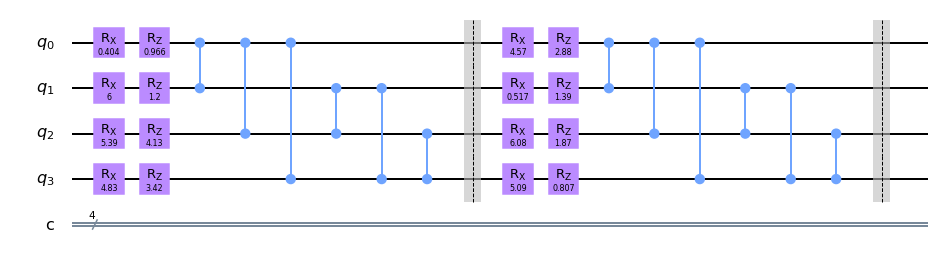

In [10]:
qc.draw(output='mpl')

## Optimization using `Qiskit Aer StatevectorSimulator`

In [11]:
backend = Aer.get_backend('statevector_simulator')

job = execute(qc, backend)

result = job.result()

outputstate = result.get_statevector(qc, decimals=3)
print(outputstate)

[ 0.58570531+0.07512564j -0.09096799-0.59938896j  0.12496195-0.00169711j
  0.07448214+0.12975276j  0.04399841-0.0148838j  -0.08128006-0.01202914j
  0.01861769-0.02172722j -0.06202611-0.02135791j -0.05633756-0.04744972j
  0.00739247+0.17348103j -0.05562277-0.02614597j -0.00320218+0.13781164j
  0.18649211+0.16152531j  0.11894497-0.28829342j  0.05981527+0.0384931j
 -0.00915242+0.10050456j]


In [12]:
def get_outputstate(n_layers, params):
    
    backend = Aer.get_backend('statevector_simulator')
    
    qc = build_variational_circuit(n_layers, params)
    
    job = execute(qc, backend)
    
    result = job.result()

    outputstate = result.get_statevector(qc, decimals=3)
    
    return outputstate

def get_measurement(n_layers, params):
    
    qc = build_variational_circuit(n_layers, params)
    NUM_SHOTS = 10000
    backend = Aer.get_backend("qasm_simulator")
    qc.measure_all()
    result = execute(qc, backend, shots = NUM_SHOTS).result()
    counts = result.get_counts(qc)
    
    return counts
    

def norm_vector_difference(params):

    outputstate = get_outputstate(n_layers, params)
    
    diff = outputstate - target_vector
    
    
    return norm(diff)

def get_probability_distribution(counts):
    output_distr = [v / NUM_SHOTS for v in counts.values()]
    if len(output_distr) == 1:
        output_distr.append(0)
    output_distr = np.asarray(output_distr)
    
    return output_distr

def probability_difference(params):
    # Obtain a quantum circuit instance from the paramters
    qc = build_variational_circuit(n_layers, params)
    # Measure all qubits
    qc.measure_all()
    # Execute the quantum circuit to obtain the probability distribution associated with the current parameters
    result = execute(qc, backend, shots=NUM_SHOTS).result()
    # Obtain the counts for each measured state, and convert those counts into a probability vector
    output_distr = get_probability_distribution(result.get_counts(qc))
    # Calculate the cost as the distance between the output distribution and the target distribution
    cost = sum([np.square(output_distr[i] - target_distr[i]) for i in range(output_distr.shape[0])])
    return cost

## Random target quantum state initialization.

In [13]:
n_qubits = 4
dim = n_qubits**2
target_vector = random_quantum_state(dim)
target_distr = get_probabilities(target_vector)

## Optimization routine with different number of layers

In [14]:
# Initialize the COBYLA optimizer
optimizer = COBYLA(maxiter=1000, tol=0.0001)

# Create the initial parameters (noting that our single qubit variational form has 3 parameters)
cost_list = []
params_list = []
for n_layers in range(1,11):
    n_parameters_per_layer = 8
    params = np.random.rand(n_layers*n_parameters_per_layer)*2*np.pi
    ret = optimizer.optimize(num_vars=n_layers*n_parameters_per_layer, objective_function=norm_vector_difference, 
                             initial_point=params)

    # Obtain the output distribution using the final parameters
    qc = build_variational_circuit(n_layers, ret[0])
    final_vector = execute(qc, backend).result().get_statevector(qc, decimals = 3)
    
    #save cost function values
    cost_list.append(ret[1])
    params_list.append(ret[0])
    
    if n_layers in range(1,11,3):
        print("Number of layers:", n_layers)
        print("Target Vector:", target_vector)
        print("Obtained Vector:", final_vector)
        print("Norm difference:", ret[1])
        print("Parameters Found:", ret[0])
        print('')

Number of layers: 1
Target Vector: [0.05364644+0.00546853j 0.18961404+0.03537731j 0.08766067+0.26252606j
 0.21555984+0.29158401j 0.05547054+0.05650624j 0.13571611+0.28806265j
 0.28505724+0.16200171j 0.10312705+0.14873846j 0.28243006+0.07342644j
 0.1289436 +0.30516783j 0.16975942+0.07069355j 0.18711672+0.02441802j
 0.3230559 +0.21037946j 0.19628598+0.17043683j 0.07165128+0.05379932j
 0.07767769+0.0962586j ]
Obtained Vector: [ 0.16074496+0.j          0.26003361-0.18003653j  0.01876213-0.10115463j
  0.08294348+0.18464948j  0.07330359-0.15618635j  0.0563492 +0.33476027j
  0.08972998+0.06435901j  0.21723719+0.00361337j  0.10069234-0.17802413j
  0.03650164+0.40076253j  0.10027539+0.08414328j  0.25645492+0.02380695j
  0.12705735+0.17902009j  0.40604284+0.14729094j  0.12748504-0.05906028j
 -0.14008146+0.2383255j ]
Norm difference: 0.8098432905488306
Parameters Found: [4.0820321  1.13865413 4.64167918 1.80938393 4.10680984 0.18339552
 3.58040805 0.51474928]

Number of layers: 4
Target Vector: [

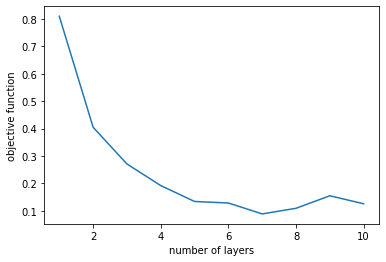

In [15]:
n_layers = range(1,11)
plt.plot(n_layers, cost_list)
plt.xlabel("number of layers")
plt.ylabel("objective function")
plt.show()

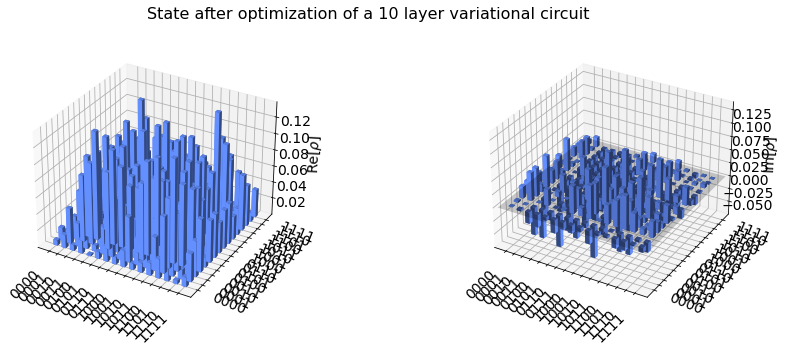

In [16]:
plot_density_matrix(10, params_list[9])

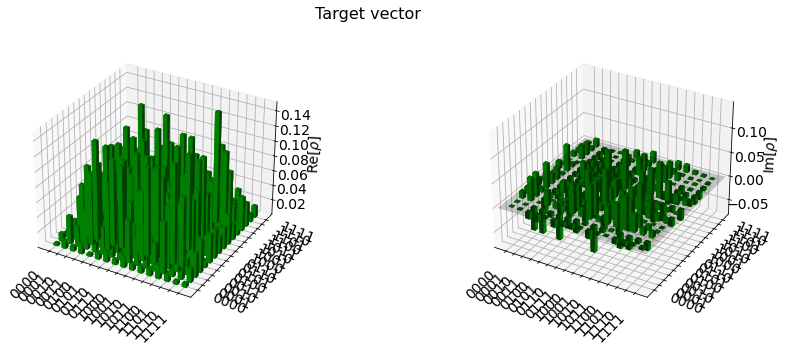

In [17]:
plot_state_city(target_vector, title='Target vector', color = ['green', 'green'])

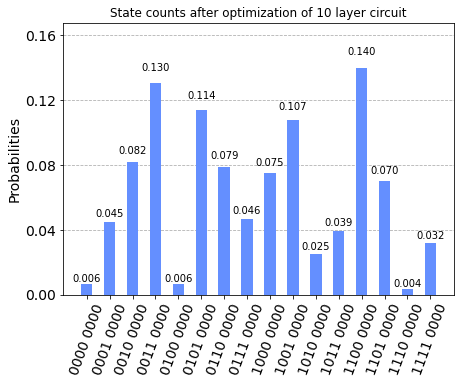

In [18]:
plot_measurements(10, params_list[9])

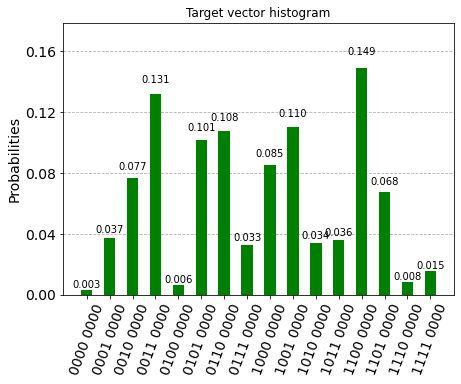

In [19]:
NUM_SHOTS = 10000
counts = get_measurement(10, params_list[9])
counts_target = {list(counts.keys())[i]: target_distr[i]*NUM_SHOTS for i in range(target_distr.shape[0])}
plot_histogram(counts_target, title='Target vector histogram', color = 'green')

In [20]:
n_layers = 10
print(f"Norm of the difference: {norm_vector_difference(params_list[9])}")
output_state = get_outputstate(n_layers, params_list[9])
print(f"Quantum fidelity: {quantum_fidelity(output_state, target_vector)}")

Norm of the difference: 0.12596949060307308
Quantum fidelity: 0.985455577668772


In [21]:
backend = Aer.get_backend("qasm_simulator")
NUM_SHOTS = 10000

# Initialize the COBYLA optimizer
optimizer = COBYLA(maxiter=1000, tol=0.0001)

# Create the initial parameters (noting that our single qubit variational form has 3 parameters)
n_parameters_per_layer = 8
cost_list = []
params_list = []
for n_layers in range(1,11):
    params = np.random.rand(n_layers*n_parameters_per_layer)*2*np.pi
    ret = optimizer.optimize(num_vars=n_layers*n_parameters_per_layer, objective_function=probability_difference, 
                             initial_point=params)

    # Obtain the output distribution using the final parameters
    qc = build_variational_circuit(n_layers, ret[0])
    qc.measure_all()
    counts = execute(qc, backend, shots=NUM_SHOTS).result().get_counts(qc)
    output_distr = get_probability_distribution(counts)
    
    cost_list.append(ret[1])
    params_list.append(ret[0])
    
    if n_layers in range(1,11,3):
        print("Number of layers:", n_layers)
        print("Target Distribution:", target_distr)
        print("Obtained Distribution:", output_distr)
        print("Output Error (square-error):", ret[1])
        print("Parameters Found:", ret[0])
        print('')

Number of layers: 1
Target Distribution: [0.00290784 0.03720504 0.07660432 0.13148728 0.00626994 0.10139895
 0.10750218 0.03275832 0.08515818 0.10975386 0.03381584 0.03560891
 0.14862463 0.0675769  0.00802827 0.01529954]
Obtained Distribution: [0.0581 0.0678 0.0329 0.0427 0.0473 0.0683 0.0299 0.0397 0.0861 0.1136
 0.0497 0.0609 0.0855 0.114  0.0444 0.0591]
Output Error (square-error): 0.033928851335728635
Parameters Found: [4.57883878 7.56959833 4.73659337 1.78399492 4.78103062 5.47693228
 1.86669342 3.86559154]

Number of layers: 4
Target Distribution: [0.00290784 0.03720504 0.07660432 0.13148728 0.00626994 0.10139895
 0.10750218 0.03275832 0.08515818 0.10975386 0.03381584 0.03560891
 0.14862463 0.0675769  0.00802827 0.01529954]
Obtained Distribution: [0.003  0.0315 0.0867 0.1259 0.017  0.1084 0.1052 0.0242 0.0876 0.1085
 0.0371 0.0428 0.1406 0.0599 0.0184 0.0032]
Output Error (square-error): 0.0007997019511507676
Parameters Found: [2.82379495 3.90053278 2.40381353 3.04503643 1.831881

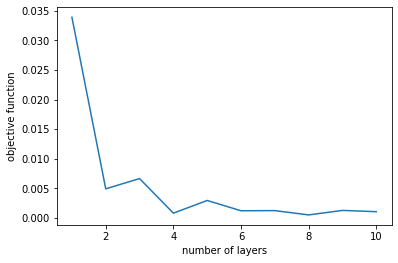

In [22]:
n_layers = range(1,11)
plt.plot(n_layers, cost_list)
plt.xlabel("number of layers")
plt.ylabel("objective function")
plt.show()

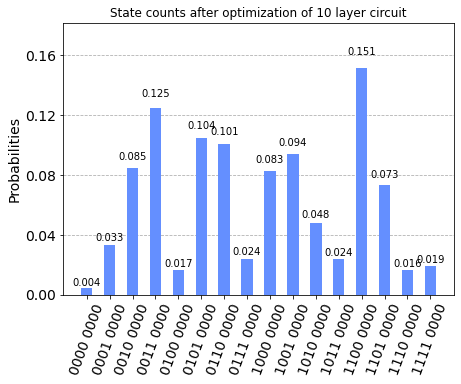

In [23]:
plot_measurements(10, params_list[9])

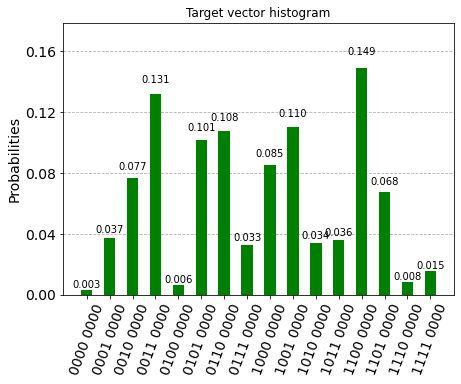

In [24]:
NUM_SHOTS = 10000
counts = get_measurement(10, params_list[9])
counts_target = {list(counts.keys())[i]: target_distr[i]*NUM_SHOTS for i in range(target_distr.shape[0])}
plot_histogram(counts_target, title='Target vector histogram', color = 'green')

In [25]:
n_layers = 10
print(f"Norm of the difference: {norm_vector_difference(params_list[9])}")
output_state = get_outputstate(n_layers, params_list[9])
print(f"Quantum fidelity: {quantum_fidelity(output_state, target_vector)}")

Norm of the difference: 1.326719488675484
Quantum fidelity: 0.02139807291441944


## Optimize the variational circuit using Pennylane

In [26]:
dev = qml.device('default.qubit', wires = 4)

In [27]:
density_matrix = density_matrix(target_vector)

In [28]:
def layer_pennylane(params: np.array) -> None:
    
    n_parameters = 8
    
    if params.shape[0] != n_parameters:
        print(f"Alert! You gave {params.shape[0]} parameters for a layer of {n_parameters} parameters.")
        
    else:
        odd_block_pennylane(params[:int(n_parameters/2)])
        even_block_pennylane(params[int(n_parameters/2):])

def odd_block_pennylane(params: np.array) -> None:
    
    n_parameters = 4
    
    if params.shape[0] != n_parameters:
        print(f"Alert! You gave {params.shape[0]} parameters for a block of {n_parameters} parameters.")
        
    else:
    
        for i in range(n_parameters):
            qml.RX(params[i], wires = i)
        

def even_block_pennylane(params: np.array) -> None:
    
    n_parameters = 4
    
    if params.shape[0] != n_parameters:
        print(f"Alert! You gave {params.shape[0]} parameters for a block of {n_parameters} parameters.")
        
    else:
    
        for i in range(n_parameters):
            qml.RZ(params[i], wires = i)

        tuples = [(i,j) for i in range(n_parameters) for j in range(n_parameters) if i < j]

        for tup in tuples:
            qml.CZ(wires=[tup[0], tup[1]])

In [29]:
@qml.qnode(dev)
def var_circuit(params):

    #number of parameters per layer
    n_parameters_per_layer = 8
    for i in range(number_layers):
        start = i*n_parameters_per_layer
        end = (i+1)*n_parameters_per_layer 
        layer_pennylane(params[start:end])

    return qml.expval(qml.Hermitian(density_matrix, wires=[0,1,2,3]))

In [30]:
def cost(x):
    
    return np.sqrt((1.0 - var_circuit(x)))

In [31]:
n_parameters_per_layer = 8
number_layers = 1
params = np.random.rand(number_layers*n_parameters_per_layer)*2*np.pi

circ = var_circuit(params)
print(norm(dev.state - target_vector))
print(quantum_fidelity(dev.state, target_vector))

1.2992443293950453
0.04498622404722196


In [32]:
cost_list = []
params_list = []
for number_layers in range(1,11):
    init_params = np.random.rand(number_layers*n_parameters_per_layer)*2*np.pi
    opt = qml.GradientDescentOptimizer(stepsize = 0.1)

    steps = 100

    params = init_params
    for i in range(steps):

        params = opt.step(cost, params)

    print(cost(params))
    cost_list.append(cost(params))
    params_list.append(params)

0.8859934304279097
0.9007861101665584
0.4171875761009648
0.5521462836650595
0.3995522288993078
0.07249641440520015
0.1296501912543216
0.07931933462593664
0.16066513079363876
0.111289914983295


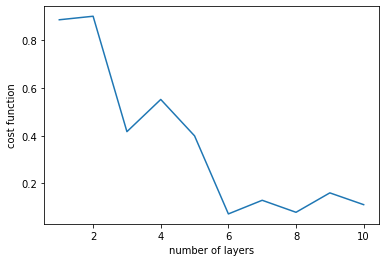

In [33]:
n_layers = range(1,11)
plt.plot(n_layers, cost_list)
plt.xlabel("number of layers")
plt.ylabel("cost function")
plt.show()

In [34]:
circuit = var_circuit(params_list[9])
output_state = dev.state
print(f"Norm of the differece: {norm(output_state - target_vector)}")
print(f"Quantum Fidelity: {quantum_fidelity(output_state, target_vector)}")

Norm of the differece: 1.4777811607695157
Quantum Fidelity: 0.9876145548230123


## Conclusions